In [27]:
%matplotlib inline
import numpy as np
from sklearn import tree
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

##Reading data

In [8]:
base_dir = 'd:/GitHub/python-2-work/'
h = np.loadtxt(base_dir + 'data/2011/2011080100_hiromb_GI_60x434.txt') - 37.356
s = np.loadtxt(base_dir + 'data/2011/2011080100_swan_GI_48x434.txt')
n = np.loadtxt(base_dir + 'data/2011/2011080100_noswan_GI_48x434.txt')
m = np.loadtxt(base_dir + 'data/2011/2011080100_measurements_GI_2623.txt')

N = 430
T = 48

# preparing measurements forecast
m_fc = np.zeros((N, T+1))
for i in range(N):
    for j in range(T+1):
        m_fc[i, j] = m[i*6+j]

# data cut and shifting
shift_const = 0
h = h[0:N, 1:T+1] + shift_const
s = s[0:N, 1:T+1] + shift_const
n = n[0:N, 1:T+1] + shift_const
m_fc = m_fc[0:N, 1:T+1] + shift_const

In [38]:
err_h = h - m_fc
err_s = s - m_fc
err_n = n - m_fc
err_all = np.hstack((err_h, err_s, err_n))
err_all.shape

(430, 144)

In [44]:
err_bias = np.vstack((np.mean(err_h, axis = 1), np.mean(err_s, axis = 1), np.mean(err_n, axis = 1)))
err_mae = np.vstack((np.mean(np.abs(err_h), axis = 1), np.mean(np.abs(err_s), axis = 1), np.mean(np.abs(err_n), axis = 1)))
err_stdev = np.vstack((np.std(err_h, axis = 1), np.std(err_s, axis = 1), np.std(err_n, axis = 1)))
err_avg = np.hstack((err_bias.transpose(), err_mae.transpose(), err_stdev.transpose()))
err_avg.shape

(430, 9)

In [49]:
diff_all = np.hstack((h - s, h - n, s - n))
diff_all.shape

(430, 144)

##PCA test

C:\Users\sergey\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


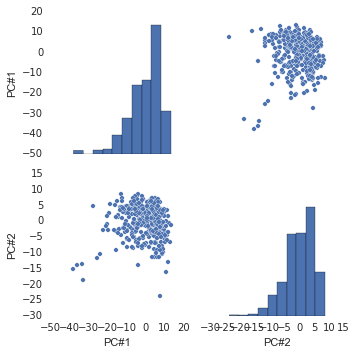

In [122]:
pc_n = 2
pca = PCA(n_components=pc_n)
pca_res = pca.fit_transform(err_avg)
df1 = pd.DataFrame(pca_res, columns=['PC#'+str(i+1) for i in range(pc_n)])
pca_res = pca.fit_transform(diff_all)
df2 = pd.DataFrame(pca_res, columns=['PC#'+str(i+1) for i in range(pc_n)])
sns.pairplot(df1)

C:\Users\sergey\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


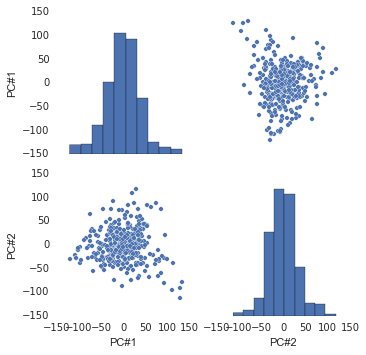

In [136]:
pc_n = 2
pca = PCA(n_components=pc_n)
pca_res = pca.fit_transform(diff_all)
df2 = pd.DataFrame(pca_res, columns=['PC#'+str(i+1) for i in range(pc_n)])
sns.pairplot(df2)

##SOM experimen

In [149]:
d = err_avg # diff_all
m_size = (20, 20)
m_len = m_size[0]*m_size[1]
m_index = np.array([[i // m_size[1], i % m_size[1]] for i in range(m_len)])
d_min = np.min(d)
d_max = np.max(d)
w = d_min + (np.random.rand(m_len, d.shape[1]) - 0.5) * (d_max - d_min)
def w_dist(x1, x2):
    return np.sqrt(np.sum(np.square(x1 - x2)))
def m_dist(i1, i2):
    return abs(m_index[i1, 0] - m_index[i2, 0]) + abs(m_index[i1, 1] - m_index[i2, 1])
def winner_index(x):
    return np.argmin([w_dist(x, w[i]) for i in range(m_len)])
def get_h(w_i, t):
    a = 1.0 / (t * 5e-4 + 1.0)
    s = 2 * 1.0 / ((t * 2e-3 + 1.0) ** 2)
    return a * np.exp(-np.array([m_dist(w_i, i) for i in range(m_len)]) / s)
for t in range(N):
    x = d[t]
    w_i = winner_index(x)
    th = get_h(w_i, t)
    for i in range(m_len):
        w[i] = w[i] + th[i] * (x - w[i])
dist_h = np.zeros((m_size[0], m_size[1] - 1))
dist_v = np.zeros((m_size[0] - 1, m_size[1]))
for i in range(m_size[0]):
    for j in range(m_size[1]):
        if i > 0:
            dist_v[i - 1, j] = w_dist(w[(i - 1) * m_size[1] + j], w[i * m_size[1] + j])
        if j > 0:
            dist_h[i, j - 1] = w_dist(w[i * m_size[1] + j - 1], w[i * m_size[1] + j])

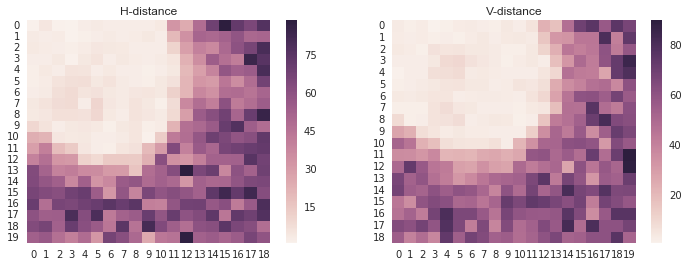

In [150]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title('H-distance')
sns.heatmap(dist_h)
plt.subplot(122)
plt.title('V-distance')
sns.heatmap(dist_v)

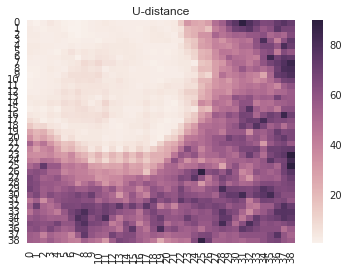

In [151]:
dist_u = np.zeros((m_size[0] * 2 - 1, m_size[1] * 2 - 1))
for i in range(m_size[0]):
    for j in range(m_size[1]):
        if i < m_size[0] - 1:
            dist_u[i * 2 + 1, j * 2] = w_dist(w[i * m_size[1] + j], w[(i + 1) * m_size[1] + j])
        if j < m_size[1] - 1:
            dist_u[i * 2, j * 2 + 1] = w_dist(w[i * m_size[1] + j], w[i * m_size[1] + j + 1])
def avg4(i ,j):
    s = 0
    n = 0
    if i > 0:
        s += dist_u[i - 1, j]
        n += 1
    if i < dist_u.shape[0] - 1:
        s += dist_u[i + 1, j]
        n += 1
    if j > 0:
        s += dist_u[i, j - 1]
        n += 1
    if j < dist_u.shape[1] - 1:
        s += dist_u[i, j + 1]
        n += 1
    dist_u[i, j] =  s / n
for i in range(m_size[0]):
    for j in range(m_size[1]):
        avg4(i * 2, j * 2)
        if (i < m_size[0] - 1) and (j < m_size[1] - 1):
            avg4(i * 2 + 1, j * 2 + 1)
plt.title('U-distance')
sns.heatmap(dist_u)

##TODO
* Tune decline function
* Tor map
* Interactive decline function
* Initialization along PC